# Generate

In [ ]:
import argparse
import os
from datetime import datetime
import pytz
import json
from collections import Counter
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import torch.nn.functional as F
import torch
# from transformers import T5ForConditionalGeneration

from src.utils.helpers import * 
from src.utils.tokenizer import *

In [ ]:
MAX_LEN = 32

In [1]:
import argparse
def parse_opt():
    ################################################################ Arguments
    parser = argparse.ArgumentParser(description='Sampling Hyperparameters')

    # Training Configuration
    parser.add_argument('--train-hyp', default="/data6/sobhan/RLLM/hyps/train.yaml", type=str, help='Training hyperparameters')
    parser.add_argument('--model-hyp', default="/data6/sobhan/RLLM/hyps/t5.yaml", type=str, help='Model hyperparameters')

    # Generation Configurations
    parser.add_argument('--checkpoints', default='/data6/sobhan/RLLM/finetune/run3_20240822-152114/checkpoints/checkpoint-350600', type=str, help='Load Model')
    parser.add_argument('--eval-dir', default="/data6/sobhan/RLLM/results/validation/pool", type=str, help='Output dir of the evaluation')
    parser.add_argument('--proteins', nargs='+', default=['hnrpnc', 'ago2', 'elavl1', 'rbm5'], type=str, help='List of protein names or IDs')
    parser.add_argument('--rna_num', default=128, type=int, help='Number of RNAs to generate per setting')

    args = parser.parse_args('')    
    args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} ID: cuda:{i}")
    return args

args = parse_opt()

NameError: name 'torch' is not defined

In [5]:
def gen_rna_batch(model, prot_ids, dec_tok, num_candidates, tolerance=5, max_token=MAX_LEN, strategy='beam_search', temperature=1.0, num_beams=5, top_k=None, top_p=None):
    inputs = torch.tensor(prot_ids, dtype=torch.long).unsqueeze(0).to(model.device)
    
    candidate_rnas = []
    while len(candidate_rnas) < num_candidates:
        with torch.no_grad():
            gen_args = {
                'max_length': 15,
                'repetition_penalty': 1.5,
                'encoder_repetition_penalty': 1.3,
                'num_return_sequences': num_candidates,
            }
            if strategy == 'beam_search':
                # For beam search, ensure that num_return_sequences <= num_beams.
                effective_beams = max(num_beams, num_candidates)
                gen_args.update({
                    'do_sample': False,
                    'num_beams': effective_beams,
                    'num_return_sequences': effective_beams,
                })
            elif strategy == 'top_k':
                gen_args.update({
                    'do_sample': True,
                    'temperature': temperature,
                    'top_k': top_k if top_k is not None else 50,
                    'num_beams': num_beams,
                })
            elif strategy == 'top_p':
                gen_args.update({
                    'do_sample': True,
                    'temperature': temperature,
                    'top_p': top_p if top_p is not None else 0.92,
                    'num_beams': num_beams,
                })
            else:  # Simple sampling
                gen_args.update({
                    'do_sample': True,
                    'temperature': temperature,
                    'num_beams': num_beams,
                })
                
            seqs = model.generate(inputs, **gen_args)
            
        decoded_rnas = [
            postprocess_rna(dec_tok.decode(seq.cpu().numpy().tolist()))
            for seq in seqs
        ]
        new_candidates = [
            rna for rna in decoded_rnas
            if (max_token - tolerance) <= len(rna) <= (max_token + tolerance)
        ]
        candidate_rnas.extend(new_candidates)
        candidate_rnas = candidate_rnas[:num_candidates]
    return candidate_rnas

In [6]:
protein_seq = read_protein_from_csv("rbm5", file_path="/data6/sobhan/dataset/proteins/protein_seqs.csv")

In [ ]:
gen_rna_batch(model, prot_ids, dec_tok, num_candidates, tolerance=5, max_token=MAX_LEN, strategy='beam_search', temperature=1.0, num_beams=5, top_k=None, top_p=None)

In [5]:
def pool_to_fasta(protein_name, pool, eval_dir):
    pool_filename = os.path.join(eval_dir, f"{protein_name}_pool.fasta")
    with open(pool_filename, "w") as f:
        for idx, cand in enumerate(pool):
            param_str = "_".join([f"{k}_{v}" for k, v in cand["hyperparams"].items()])
            header = f">RNA_{idx}_{cand['strategy']}_{param_str}"
            f.write(header + "\n")
            f.write(cand["rna"] + "\n")
    print(f"Pool file saved: {pool_filename}")
    return pool_filename

In [6]:
def create_pool(args, model, source_tokenizer, rna_tokenizer):
    grid_config = {
        'beam_search': [
            {'num_beams': 1},
            {'num_beams': 5},
            {'num_beams': 25}
        ],
        'top_k': [
            {'top_k': 30, 'temperature': 0.7, 'num_beams': 1},
            {'top_k': 30, 'temperature': 1.0, 'num_beams': 1},
            {'top_k': 30, 'temperature': 1.5, 'num_beams': 1},
            {'top_k': 100, 'temperature': 0.7, 'num_beams': 1},
            {'top_k': 100, 'temperature': 1.0, 'num_beams': 1},
            {'top_k': 100, 'temperature': 1.5, 'num_beams': 1},
        ],
        'top_p': [
            {'top_p': 0.7, 'temperature': 0.7, 'num_beams': 1},
            {'top_p': 0.7, 'temperature': 1.0, 'num_beams': 1},
            {'top_p': 0.7, 'temperature': 1.5, 'num_beams': 1},
            {'top_p': 0.9, 'temperature': 0.7, 'num_beams': 1},
            {'top_p': 0.9, 'temperature': 1.0, 'num_beams': 1},
            {'top_p': 0.9, 'temperature': 1.5, 'num_beams': 1},
        ],
        'sample': [
            {'temperature': 0.7, 'num_beams': 1},
            {'temperature': 1.0, 'num_beams': 1},
            {'temperature': 1.5, 'num_beams': 1},
        ]
    }
    
    os.makedirs(args.eval_dir, exist_ok=True)
    for protein_name in args.proteins:
        protein_seq = read_protein_from_csv(protein_name, file_path="/data6/sobhan/dataset/proteins/protein_seqs.csv")
        if protein_seq is None:
            print(f"Warning: Protein {protein_name} not found.")
            continue
        print("Tokenizing Protein:", protein_name)
        prot_ids = source_tokenizer.tokenize(protein_seq).ids
        
        pool = []
        for strategy, hyper_list in grid_config.items():
            for hyperparams in hyper_list:
                temperature = hyperparams.get('temperature', 1.0)
                num_beams = hyperparams.get('num_beams', 1)
                top_k = hyperparams.get('top_k', None)
                top_p = hyperparams.get('top_p', None)
                
                print(f"Generating for Protein: {protein_name}, Strategy: {strategy}, Hyperparameters: {hyperparams}")
                candidate_rnas = gen_rna_batch(
                    model,
                    prot_ids,
                    rna_tokenizer,
                    args.rna_num,
                    strategy=strategy,
                    temperature=temperature,
                    num_beams=num_beams,
                    top_k=top_k,
                    top_p=top_p
                )
                for idx, rna in enumerate(candidate_rnas):
                    pool.append({
                        "rna": rna,
                        "strategy": strategy,
                        "hyperparams": hyperparams,
                        "id": f"RNA_{idx}_{strategy}_{'_'.join([f'{k}_{v}' for k,v in hyperparams.items()])}"
                    })
        
        pool_file = pool_to_fasta(protein_name, pool, args.eval_dir)

Number of GPUs available: 1
GPU 0: NVIDIA GeForce RTX 2080 Ti
GPU 0 ID: cuda:0


In [7]:
model = T5ForConditionalGeneration.from_pretrained(args.checkpoints).to(args.device)
model.eval()

source_tokenizer = get_tokenizer(
    tokenizer_name=args.tokenizer,
    vocab_size=args.vocab_size,
    seq_size=args.seq_size,
    tokenizer_path=args.source_tokenizer
)
rna_tokenizer = get_tokenizer(
    tokenizer_name=args.tokenizer,
    vocab_size=args.vocab_size,
    seq_size=args.seq_size,
    tokenizer_path=args.rna_tokenizer
)

NameError: name 'T5ForConditionalGeneration' is not defined

In [9]:
create_pool(args, model, source_tokenizer, rna_tokenizer)

Tokenizing Protein: hnrpnc
Generating for Protein: hnrpnc, Strategy: beam_search, Hyperparameters: {'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: beam_search, Hyperparameters: {'num_beams': 5}
Generating for Protein: hnrpnc, Strategy: beam_search, Hyperparameters: {'num_beams': 25}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 30, 'temperature': 0.7, 'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 30, 'temperature': 1.0, 'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 30, 'temperature': 1.5, 'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 100, 'temperature': 0.7, 'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 100, 'temperature': 1.0, 'num_beams': 1}
Generating for Protein: hnrpnc, Strategy: top_k, Hyperparameters: {'top_k': 100, 'temperature': 1.5, 'num_beams': 1}
Genera

KeyboardInterrupt: 

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import json
import copy 
from collections import Counter
import numpy as np

from src.utils.validations import calculate_mfe_many
from src.utils.helpers import read_protein_from_csv


project1_path = '/data6/sobhan/deepclip'
sys.path.append(project1_path)
import constants
import network
from data_gen import onehot_encode
from data_gen import onehot_binary

def encode_input_data(seqs, max_length):
    pad_sequences_with_N(seqs, max_length)
    return seqs

def pad_sequences_with_N(added_seqs, length):
    for i in range(len(added_seqs)):
        begin = end = 0  # make sure these are zero
        if len(added_seqs[i]) < length:
            missing = int(length - len(added_seqs[i]))
            begin = int(missing/2)
            end = int(missing - begin)
        added_seqs[i] = begin*'n' + added_seqs[i] + end*'n'
        if len(added_seqs[i]) != length:
            print(str(len(added_seqs[i])))
            print(str(i))
            break
    return added_seqs


clip_directory = "/data6/sobhan/RLLM_OPT/deepclip_models" 

In [2]:
def calc_deep_clip(rna_sequences, protein_name) -> int:
    clip_file = next(
        (os.path.join(root1, file1) for root1, _, files1 in os.walk(clip_directory)
            for file1 in files1 if protein_name.lower() in file1.lower()),
        None
    )
    print("DeepCLIP file: ", clip_file)
    try:
        net, freq = network.load_network(clip_file)
        options = net.options
        predict_fn, outpar = net.compile_prediction_function()
        output_shape = net.network['l_in'].output_shape
    except Exception as e:
        raise ValueError(f"Error loading network: {e}")

    max_filter_size = max(options["FILTER_SIZES"]) / len(constants.VOCAB)
    max_network_length = int(options["SEQ_SIZE"] - 2 * (max_filter_size - 1))
    max_input_length = max(map(len, rna_sequences))

    if max_input_length > max_network_length:
        raise ValueError(f"Input sequences exceed the maximum network length ({max_network_length}).")

    # Encode and predict
    seq_list = encode_input_data(rna_sequences, max_network_length + 2 * (max_filter_size - 1))
    X_test = onehot_encode(seq_list, freq, vocab=constants.VOCAB)
    results = network.predict_without_network(predict_fn, options, output_shape, X_test, outpar)
    predictions = results["predictions"]
    return predictions

In [3]:
def read_fasta(fasta_file):
    candidates = []
    with open(fasta_file, 'r') as f:
        header = None
        seq_lines = []
        for line in f:
            line = line.strip()
            if not line:
                continue
            if line.startswith(">"):
                if header is not None:
                    candidates.append({"header": header, "rna": "".join(seq_lines)})
                header = line[1:]
                seq_lines = []
            else:
                seq_lines.append(line)
        if header is not None:
            candidates.append({"header": header, "rna": "".join(seq_lines)})
    return candidates

In [21]:
import argparse
def parse_opt():
    ################################################################ Arguments
    parser = argparse.ArgumentParser(description='Sampling Hyperparameters')

    # Training Configuration
    parser.add_argument('--train-hyp', default="/data6/sobhan/RLLM/hyps/train.yaml", type=str, help='Training hyperparameters')
    parser.add_argument('--model-hyp', default="/data6/sobhan/RLLM/hyps/t5.yaml", type=str, help='Model hyperparameters')

    # Generation Configurations
    parser.add_argument('--checkpoints', default='/data6/sobhan/rllm/results/train/t5/run3_20240822-152114/checkpoints/checkpoint-349800', type=str, help='Load Model')
    parser.add_argument('--eval-dir', default="/data6/sobhan/RLLM/results/validation/pool", type=str, help='Output dir of the evaluation')
    parser.add_argument('--proteins', nargs='+', default=['hnrpnc', 'ago2', 'elavl1', 'rbm5'], type=str, help='List of protein names or IDs')
    parser.add_argument('--rna_num', default=128, type=int, help='Number of RNAs to generate per setting')
    parser.add_argument('--top_num', default=10, type=int, help='Number of TOP n RNAs to be selected from the Pool of RNAs')


    args = parser.parse_args('')    
    return args

args = parse_opt()

In [16]:

def calc_scores(candidates, phi_cons=0.3, phi2_mfe=0.1, phi3_bind=1):
    rnas = [cand['rna'] for cand in candidates]

    #Binding Affinity
    predictions = calc_deep_clip(copy.deepcopy(rnas), protein_name) 

    #Foldability
    mfes = calculate_mfe_many(copy.deepcopy(rnas)) 
    np_mfes = np.array(copy.copy(mfes))
    normalized_mfes = list(1 - (mfes - np.min(np_mfes)) / (np.max(np_mfes) - np.min(np_mfes)))

    # Consistency score
    vote_counts = Counter(copy.deepcopy(rnas))
    max_vote = vote_counts.most_common(1)[0][1]

    for index, cand in enumerate(candidates):
        cand["deepclip_score"] = predictions.pop(0)[0]
        cand["MFE"] = mfes.pop(0)
        cand["MFE_score"] = normalized_mfes.pop(0)
        cand["vote_score"] = vote_counts[cand["rna"]] / max_vote
        cand["final_score"] = phi3_bind*cand["deepclip_score"] + phi2_mfe*cand["MFE_score"] + phi_cons*cand["vote_score"]

    return candidates



In [ ]:
for protein_name in args.proteins:
    protein_seq = read_protein_from_csv(protein_name, file_path="/data6/sobhan/dataset/proteins/protein_seqs.csv")
    print(protein_name)
    if protein_seq is None:
        continue
    pool_file = os.path.join(args.eval_dir, f"{protein_name}_pool.fasta")
    if os.path.exists(pool_file):
        candidates = read_fasta(pool_file) # READING POOL FILE
        candidates = calc_scores(candidates) # CALCULATING SCORES
        sorted_candidates = sorted(candidates, key=lambda x: x["final_score"], reverse=True) # SORTING

        # Remove the duplicated RNAs
        seen = set()
        unique_candidates = []
        for cand in sorted_candidates:
            if cand["rna"] not in seen:
                unique_candidates.append(cand)
                seen.add(cand["rna"])
            if len(unique_candidates) >= args.top_num:
                break

        filtered_filename = os.path.join(os.path.dirname(pool_file), f"{protein_name}_filtered.fasta")
        with open(filtered_filename, "w") as f:
            for idx, cand in enumerate(unique_candidates):
                header = f">RNA_{idx}_{cand.get('header', 'NA')}_score_{cand['final_score']:.3f}"
                f.write(header + "\n")
                f.write(cand["rna"] + "\n")
    else:
        print(f"Pool file for {protein_name} not found.")



hnrpnc
DeepCLIP file:  /data6/sobhan/RLLM_OPT/deepclip_models/hnRPNC_GP.pkl
 Making prediction function ...

In [18]:
candidates

[{'header': 'RNA_0_beam_search_num_beams_1',
  'rna': 'AUGGCCCUCCCGACACCUUCGGACAGC',
  'deepclip_score': 0.022768741437720605,
  'MFE': -4.099999904632568,
  'vote_score': 0.631578947368421,
  'final_score': 0.23122390635298748,
  'MFE_score': 0.18981480704740583},
 {'header': 'RNA_1_beam_search_num_beams_1',
  'rna': 'AUGAGCGCUAGCGGCCCCGAGGCUCCUGGGGACAUU',
  'deepclip_score': 0.0011872412820267903,
  'MFE': -11.699999809265137,
  'vote_score': 0.7894736842105263,
  'final_score': 0.29219601137220186,
  'MFE_score': 0.5416666482701717},
 {'header': 'RNA_2_beam_search_num_beams_1',
  'rna': 'UGGGGCGGGGCAGGGGCGCUCCCAGCC',
  'deepclip_score': 0.05052844881468488,
  'MFE': -10.899999618530273,
  'vote_score': 0.5263157894736842,
  'final_score': 0.2588861459624816,
  'MFE_score': 0.5046296030569146},
 {'header': 'RNA_3_beam_search_num_beams_1',
  'rna': 'CGGGGACGGGGGCACAAUCCCGGGGCCCCC',
  'deepclip_score': 0.09460351340439217,
  'MFE': -14.800000190734863,
  'vote_score': 0.473684210526315

# Evaluate

In [11]:
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read DeepClip output from a JSON file
def read_deepclip_output(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    scores = {}
    # Group predictions based on the first two parts of the id
    for prediction in data.get("predictions", []):
        parts = prediction["id"].split("_")
        group_name = parts[0] + " " + parts[1]
        if group_name not in scores:
            scores[group_name] = []
        scores[group_name].append(prediction["score"])
    return scores


# Grouped Box Plot: X-axis is Protein, hue is Group
def plot_grouped_boxplot(df, output_path):
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Protein", y="Score", hue="Group", data=df, palette="Set2")
    plt.title("Binding Score by Protein and Group")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

# Grouped Violin Plot: X-axis is Protein, hue is Group (using split violins if possible)
def plot_grouped_violin(df, output_path):
    plt.figure(figsize=(10, 6))
    # If there are exactly 2 groups per protein you can split the violin
    # Otherwise, remove 'split=True' so that each violin is shown side-by-side.
    sns.violinplot(x="Protein", y="Score", hue="Group", data=df, palette="Set2", split=False)
    plt.title("Binding Score by Protein and Group")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

# Grouped Density Plot: Separate density curves for each group within each protein
def plot_grouped_density(df, output_path):
    plt.figure(figsize=(10, 6))
    proteins = df["Protein"].unique()
    for protein in proteins:
        subset = df[df["Protein"] == protein]
        sns.kdeplot(data=subset, x="Score", hue="Group", fill=True, alpha=0.3, common_norm=False, label=protein)
    plt.title("Density Plot by Protein and Group")
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()


In [12]:
eval_dir = "/data6/sobhan/RLLM/results/validation/test374800-filtered"

all_data = []
# Loop over each item in the evaluation directory
for protein in os.listdir(eval_dir):
    print(f"Processing {protein}")
    protein_path = os.path.join(eval_dir, protein)
    # Check if this is a directory
    if os.path.isdir(protein_path):
        print(protein[3:])
        json_file = os.path.join(protein_path, f"{protein[3:]}.json")
        print(json_file)
        if os.path.exists(json_file):
            protein_scores = read_deepclip_output(json_file)
            # For each group, add a record for every score
            for group, scores in protein_scores.items():
                for score in scores:
                    all_data.append({
                        "Protein": protein[3:],
                        "Group": group,
                        "Score": score
                    })

df = pd.DataFrame(all_data)

Processing PDBZC3H7B
ZC3H7B
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBZC3H7B/ZC3H7B.json
Processing PDBAGO2
AGO2
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBAGO2/AGO2.json
Processing PDBU2AF2
U2AF2
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBU2AF2/U2AF2.json
Processing PDBhnRPNC
hnRPNC
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBhnRPNC/hnRPNC.json
Processing PDBHNRNPA1
HNRNPA1
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBHNRNPA1/HNRNPA1.json
Processing PDBELAVL1
ELAVL1
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBELAVL1/ELAVL1.json
Processing deepclip
pclip
/data6/sobhan/RLLM/results/validation/test374800-filtered/deepclip/pclip.json
Processing PDBTARDBP
TARDBP
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBTARDBP/TARDBP.json
Processing PDBMOV10
MOV10
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBMOV10/MOV10.json


Processing PDBFUS
FUS
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBFUS/FUS.json
Processing PDBSRSF1
SRSF1
/data6/sobhan/RLLM/results/validation/test374800-filtered/PDBSRSF1/SRSF1.json


In [13]:
df

,Protein,Group,Score
0,ZC3H7B,Natural non-binding,0.643528
1,ZC3H7B,Natural non-binding,0.200377
2,ZC3H7B,Natural non-binding,0.156379
3,ZC3H7B,Natural non-binding,0.010879
4,ZC3H7B,Natural non-binding,0.543766
...,...,...,...
3319,SRSF1,RNAtranslator,0.736681
3320,SRSF1,RNAtranslator,0.696255
3321,SRSF1,RNAtranslator,0.852775
3322,SRSF1,RNAtranslator,0.450035


In [14]:
# Create an output directory for the plots
output_dir = os.path.join(eval_dir, "deepclip")
os.makedirs(output_dir, exist_ok=True)

# Plot and save the figures
plot_grouped_boxplot(df, os.path.join(output_dir, "grouped_boxplot.png"))
plot_grouped_violin(df, os.path.join(output_dir, "grouped_violin.png"))
plot_grouped_density(df, os.path.join(output_dir, "grouped_density.png"))

/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

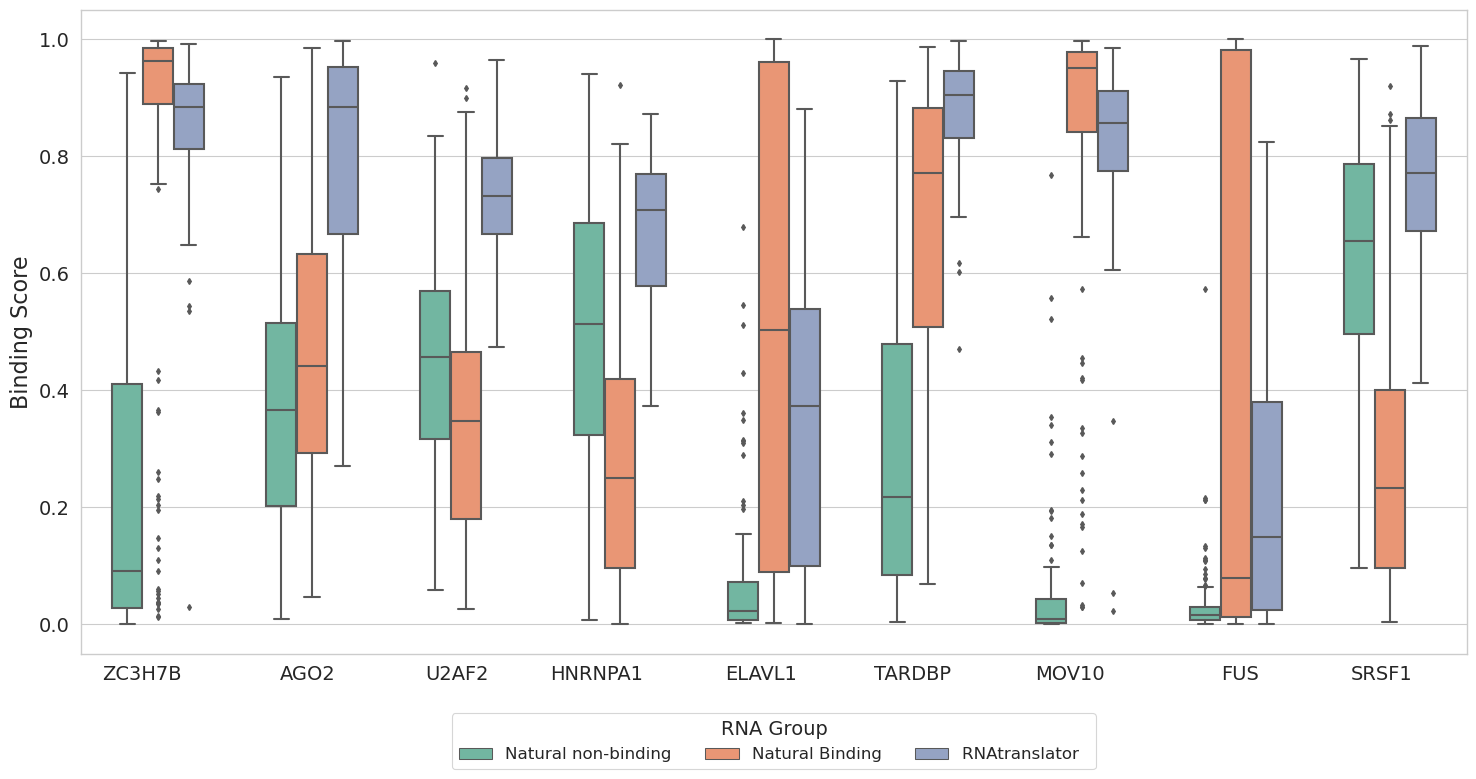

In [15]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set the figure size and academic-style parameters
plt.figure(figsize=(15, 8))
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")

# Create the boxplot with an added linewidth between protein groups
ax = sns.boxplot(
    x="Protein", y="Score", hue="Group", data=df, 
    palette="Set2", width=0.6, linewidth=1.5, fliersize=3
)

# # Add a thin separation line between proteins
# for i in range(df["Protein"].nunique() - 1):
#     plt.axvline(i + 0.5, color='gray', linestyle='dashed', linewidth=1)

# Titles and labels
# plt.title("Binding Score by Protein and RNA Group", fontsize=18, fontweight='bold')
plt.xlabel("", fontsize=16, fontweight='bold')
plt.ylabel("Binding Score", fontsize=16)

# Adjust tick labels for clarity
xticks = np.arange(len(df["Protein"].unique()))  # Get x-tick positions
plt.xticks(xticks + 0.15, df["Protein"].unique(), fontsize=14, ha='right')

plt.yticks(fontsize=14)

# Move the legend outside the plot
plt.legend(
    title="RNA Group", fontsize=12, title_fontsize=14, 
    loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=3, frameon=True, shadow=False,
)

plt.tight_layout()

# Create output directory and save the figure in high resolution
output_dir = os.path.join(eval_dir, "deepclip")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "combined_boxplot.png")
plt.savefig(output_path, dpi=600, bbox_inches="tight")  # Higher DPI for academic use
plt.show()

/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

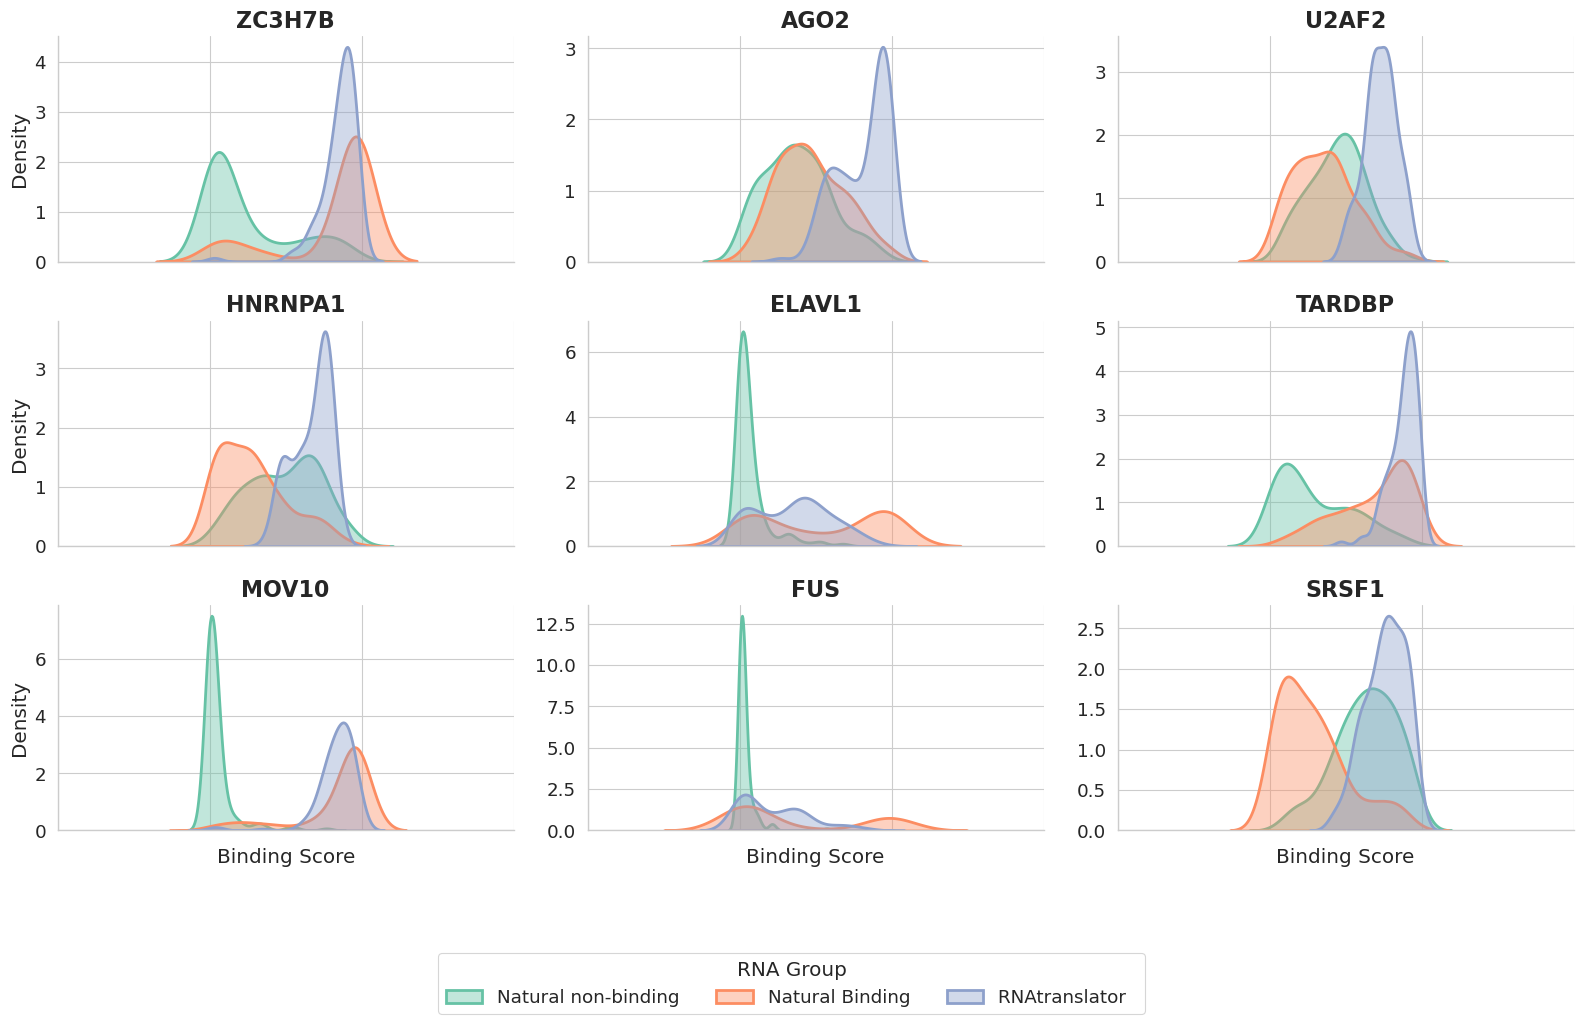

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn styling for academic use
sns.set_context("paper", font_scale=1.5)
sns.set_style("whitegrid")

# Create a FacetGrid for density plots, one for each Protein
g = sns.FacetGrid(df, col="Protein", hue="Group", col_wrap=3, sharex=True, sharey=False, palette="Set2")

# Map density plot to each facet
g.map(sns.kdeplot, "Score", fill=True, alpha=0.4, linewidth=2)

# Adjust layout
g.set_titles(col_template="{col_name}", size=16, fontweight='bold')
g.set_axis_labels("Binding Score", "Density")
g.set_xticklabels(rotation=30)
g.add_legend(title="RNA Group", loc="lower center", bbox_to_anchor=(0.5, -0.15), ncol=3, frameon=True)

plt.tight_layout()

# Create output directory and save the figure in high resolution
output_dir = os.path.join(eval_dir, "deepclip")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "density_per_protein.png")
plt.savefig(output_path, dpi=600, bbox_inches="tight")  # Higher DPI for academic use
plt.show()

# Representation

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import torch

from pathlib import Path
from transformers import T5ForConditionalGeneration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.utils.tokenizer import BpeTokenizer

# Load config for model and training
results_dir = Path("attentions")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load the T5 model
model_path = "/data6/sobhan/RLLM/finetune/checkpoint-362400"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval() # Set to evaluation mode

/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


T5ForConditionalGeneration(
  (shared): Embedding(1000, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(1000, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=768, bias=False)
              (k): Linear(in_features=512, out_features=768, bias=False)
              (v): Linear(in_features=512, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=1024, bias=False)
              (wo): Linear(in_features=1024, out_features=512, bias=False)
              (dropout): Dropo

In [2]:
from src.utils.helpers import read_protein_from_csv

protein_labels = [file.split("_")[0] for file in os.listdir("/data6/helya/dataset/CLIPdb_cluster/cd_hit_results_RBPs/identity_90")]
protein_sequences = [read_protein_from_csv(label.lower(), file_path="/data6/sobhan/dataset/proteins/protein_seqs.csv") for label in protein_labels]

In [3]:
protein_sequences

['MASRKEGTGSTATSSSSTAGAAGKGKGKGGSGDSAVKQVQIDGLVVLKIIKHYQEEGQGTEVVQGVLLGLVVEDRLEITNCFPFPQHTEDDADFDEVQYQMEMMRSLRHVNIDHLHVGWYQSTYYGSFVTRALLDSQFSYQHAIEESVVLIYDPIKTAQGSLSLKAYRLTPKLMEVCKEKDFSPEALKKANITFEYMFEEVPIVIKNSHLINVLMWELEKKSAVADKHELLSLASSNHLGKNLQLLMDRVDEMSQDIVKYNTYMRNTSKQQQQKHQYQQRRQQENMQRQSRGEPPLPEEDLSKLFKPPQPPARMDSLLIAGQINTYCQNIKEFTAQNLGKLFMAQALQEYNN',
 'MGKMAAAVGSVATLATEPGEDAFRKLFRFYRQSRPGTADLEGVIDFSAAHAARGKGPGAQKVIKSQLNVSSVSEQNAYRAGLQPVSKWQAYGLKGYPGFIFIPNPFLPGYQWHWVKQCLKLYSQKPNVCNLDKHMSKEETQDLWEQSKEFLRYKEATKRRPRSLLEKLRWVTVGYHYNWDSKKYSADHYTPFPSDLGFLSEQVAAACGFEDFRAEAGILNYYRLDSTLGIHVDRSELDHSKPLLSFSFGQSAIFLLGGLQRDEAPTAMFMHSGDIMIMSGFSRLLNHAVPRVLPNPEGEGLPHCLEAPLPAVLPRDSMVEPCSMEDWQVCASYLKTARVNMTVRQVLATDQNFPLEPIEDEKRDISTEGFCHLDDQNSEVKRARINPDS',
 'MSDSGSYGQSGGEQQSYSTYGNPGSQGYGQASQSYSGYGQTTDSSYGQNYSGYSSYGQSQSGYSQSYGGYENQKQSSYSQQPYNNQGQQQNMESSGSQGGRAPSYDQPDYGQQDSYDQQSGYDQHQGSYDEQSNYDQQHDSYSQNQQSYHSQRENYSHHTQDDRRDVSRYGEDNRGYGGSQGGGRGRGGYDKDGRGPMTGSSGGDRGGFKNFGGHRDYGPRTDADSESDNSDNNTIFVQGLGEGVST

In [4]:
protein_tokenizer = BpeTokenizer(vocab_size=1000, seq_size=1024)
protein_tokenizer.load("/data6/sobhan/RLLM/dataset/tokenizers/bpe_protein_1000_1024.json")



tokenized_sequences = []
for seq in protein_sequences:
    input_ids = protein_tokenizer.tokenize(seq)
    inputs = torch.tensor(input_ids.ids, dtype=torch.long).to(device)
    inputs = inputs.unsqueeze(0)

    tokenized_sequences.append(inputs)

# Pad sequences to max length in the batch (or a fixed length if needed, T5 handles variable length well)
padded_sequences = torch.nn.utils.rnn.pad_sequence(tokenized_sequences, batch_first=True).to(device)


enable_padding(max_length=X) is deprecated, use enable_padding(length=X) instead


In [9]:
final_encoder_representations_list = []
batch_size=32
def get_encoder_representations(model, input_ids):
    # print("Input shape:", input_ids.shape)
    outputs = model.encoder(input_ids.reshape(-1, input_ids.shape[-1]), return_dict=True)
    # print("Input shape:", input_ids.reshape(-1, input_ids.shape[-1]).shape)

    return outputs.last_hidden_state

with torch.no_grad():
    for i in range(0, len(padded_sequences), batch_size):
        batch_input = padded_sequences[i:i + batch_size]
        print(f"Processing batch from index {i} to {i + batch_size}")
        batch_encoder_representations = get_encoder_representations(model, batch_input)
        final_encoder_representations_list.append(batch_encoder_representations)

    # Concatenate representations from all batches
    final_encoder_representations = torch.cat(final_encoder_representations_list, dim=0)



Processing batch from index 0 to 32
Processing batch from index 32 to 64
Processing batch from index 64 to 96
Processing batch from index 96 to 128
Processing batch from index 128 to 160
Processing batch from index 160 to 192
Processing batch from index 192 to 224
Processing batch from index 224 to 256
Processing batch from index 256 to 288
Processing batch from index 288 to 320
Processing batch from index 320 to 352
Processing batch from index 352 to 384
Processing batch from index 384 to 416
Processing batch from index 416 to 448


In [10]:
pooled_representations = final_encoder_representations.mean(dim=1).cpu().numpy() # [batch_size, hidden_size]


In [11]:
pca = PCA(n_components=2)
reduced_representations_pca = pca.fit_transform(pooled_representations)

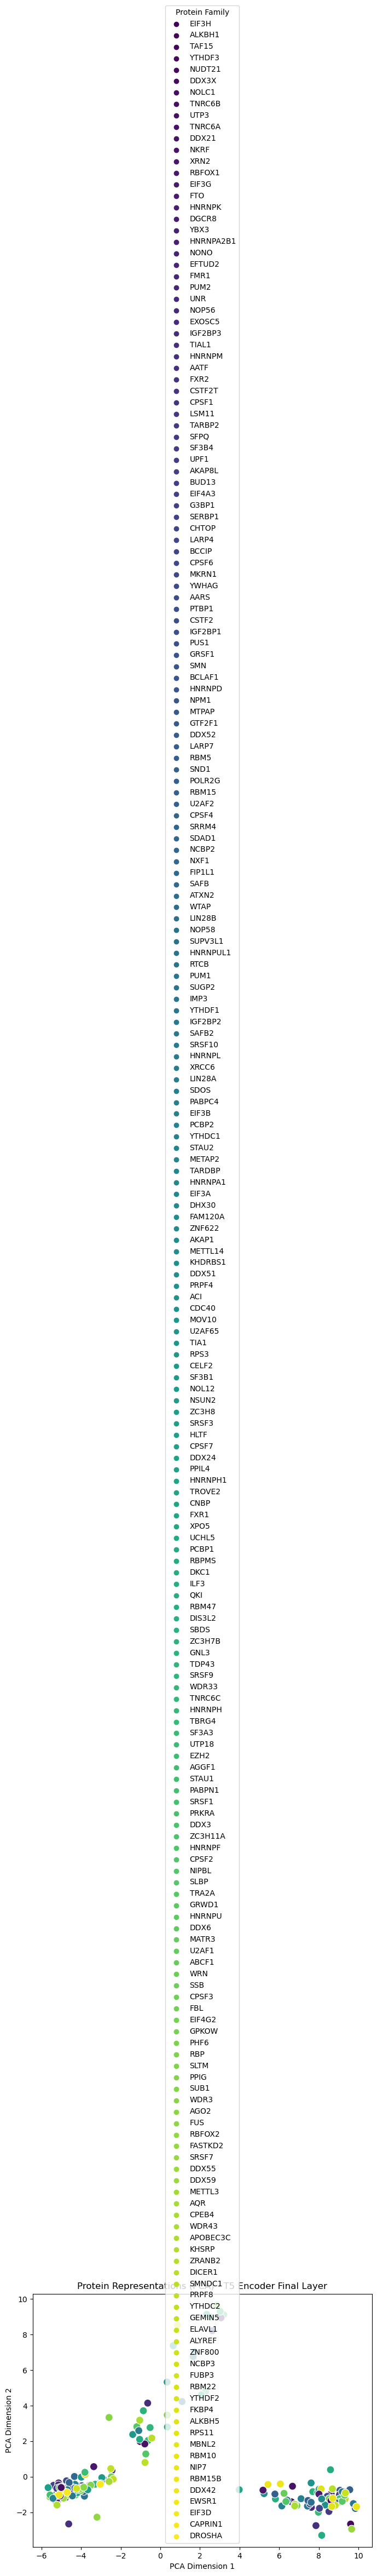

In [12]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_representations_pca[:, 0], y=reduced_representations_pca[:, 1],
                hue=protein_labels, palette="viridis", s=100)
plt.title('Protein Representations (PCA) - T5 Encoder Final Layer')
plt.xlabel('PCA Dimension 1')
plt.ylabel('PCA Dimension 2')
plt.legend(title='Protein Family')
plt.savefig(results_dir / "protein_representations_pca.png")
plt.show()

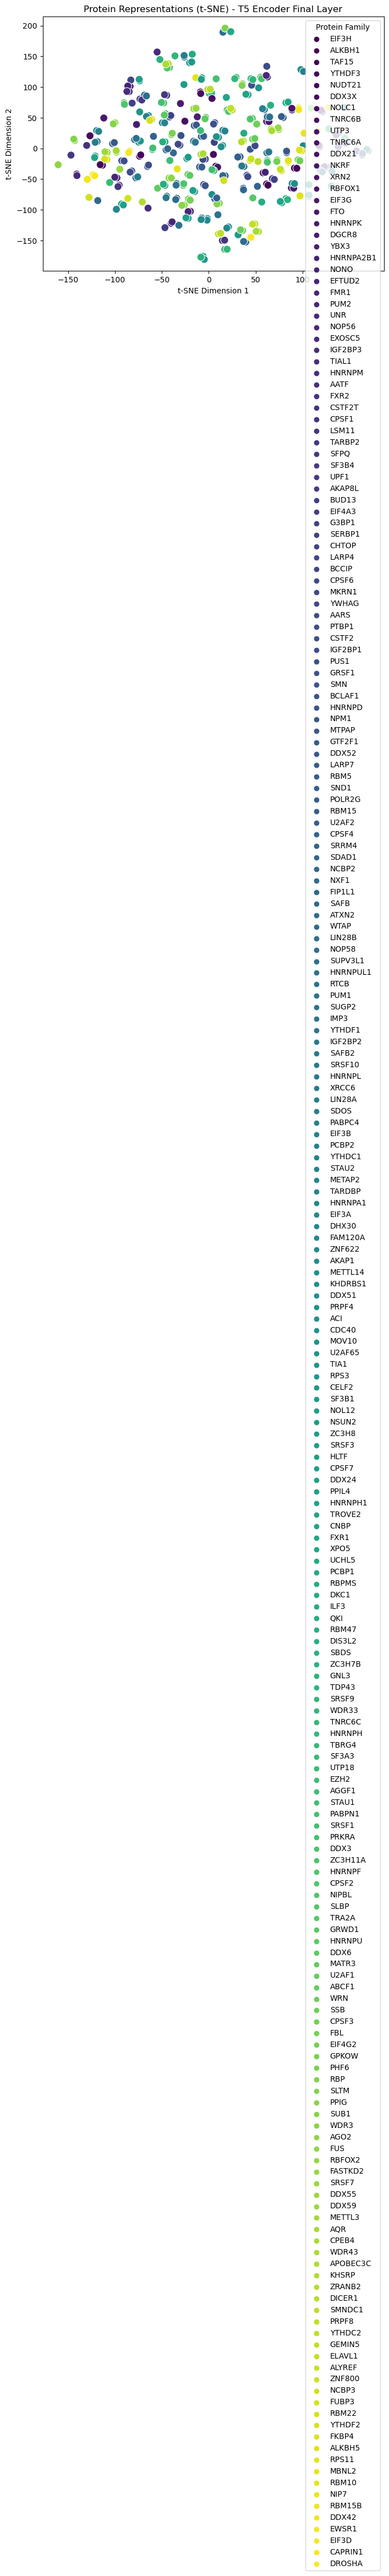

Visualizations saved to: attentions


In [13]:
tsne = TSNE(n_components=2, perplexity=min(len(protein_sequences) - 1, 3)) # Perplexity adjusted for small sample size
reduced_representations_tsne = tsne.fit_transform(pooled_representations)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_representations_tsne[:, 0], y=reduced_representations_tsne[:, 1],
                hue=protein_labels, palette="viridis", s=100)
plt.title('Protein Representations (t-SNE) - T5 Encoder Final Layer')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(title='Protein Family')
plt.savefig(results_dir / "protein_representations_tsne.png")
plt.show()

print(f"Visualizations saved to: {results_dir}")

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import torch

from pathlib import Path
from transformers import T5ForConditionalGeneration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.utils.tokenizer import BpeTokenizer

# Load config for model and training
results_dir = Path("attentions")
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Device setup
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Load the T5 model
model_path = "/data6/sobhan/RLLM/finetune/checkpoint-362400"
model = T5ForConditionalGeneration.from_pretrained(model_path).to(device)
model.eval() # Set to evaluation mode

rna_tokenizer = BpeTokenizer(vocab_size=1000, seq_size=1024)
rna_tokenizer.load("/data6/sobhan/RLLM/dataset/tokenizers/bpe_rna_1000_1024.json")

protein_tokenizer = BpeTokenizer(vocab_size=1000, seq_size=1024)
protein_tokenizer.load("/data6/sobhan/RLLM/dataset/tokenizers/bpe_protein_1000_1024.json")



/data6/sobhan/envs/rllm2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
enable_padding(max_length=X) is deprecated, use enable_padding(length=X) instead
enable_padding(max_length=X) is deprecated, use enable_padding(length=X) instead


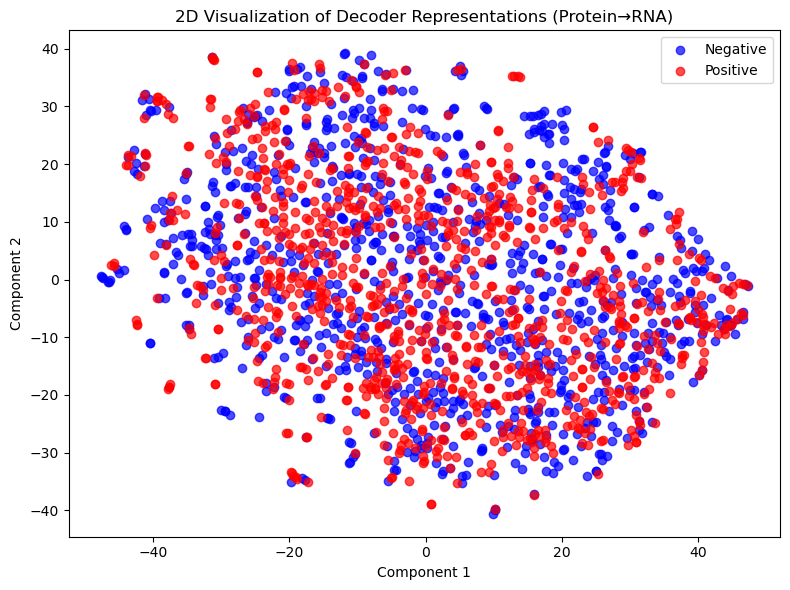

Plot saved to attentions/decoder_representation_plot.png


In [12]:

# Define the RNA preprocessing function
def preprocess_rna(rna):
    return rna.lower().replace('a', 'B').replace('c', 'J').replace('u', 'U').replace('g', 'Z')

def load_interactions(file_path, label):
    """
    Reads a file and returns a list of (interaction_string, label) tuples.
    Each line is expected to be in the format: Protein_sequence$RNA_sequence
    """
    interactions = []
    n=0
    with open(file_path, "r") as f:
        for line in f:
            line = line.strip()
            if line:
                interactions.append((line, label))
                n+=1
            if n==1000:
                break
    return interactions

# Set file paths for your interaction files
positive_file = "/data6/sobhan/dataset/prediction/ELAVL1_positives.txt"
negative_file = "/data6/sobhan/dataset/prediction/ELAVL1_negatives.txt"

# Load interactions from both files
positive_interactions = load_interactions(positive_file, label=1)
negative_interactions = load_interactions(negative_file, label=0)
all_interactions = positive_interactions + negative_interactions


representations = []
labels = []

# Process each interaction to get its decoder representation
for interaction, label in all_interactions:
    try:
        # Split the line into protein and RNA sequences using the '$' delimiter
        protein_seq, rna_seq = interaction.split('$')
    except ValueError:
        print("Skipping invalid line:", interaction)
        continue

    # Tokenize protein sequence using the protein tokenizer
    protein_tokens = protein_tokenizer.tokenize(protein_seq).ids

    # Preprocess and tokenize RNA sequence using the RNA tokenizer
    rna_seq_processed = preprocess_rna(rna_seq)
    rna_tokens = rna_tokenizer.tokenize(rna_seq_processed).ids

    # Construct the encoder input from the protein tokens
    encoder_input_ids = torch.tensor([protein_tokens]).to(device)

    # Construct the decoder input: prepend the decoder start token if not present
    # (T5 models require the decoder start token to begin decoding.)
    decoder_input_ids_list = [model.config.decoder_start_token_id] + rna_tokens
    decoder_input_ids = torch.tensor([decoder_input_ids_list]).to(device)

    # Forward pass through the model with teacher forcing: encoder gets protein tokens, decoder gets RNA tokens
    with torch.no_grad():
        outputs = model(
            input_ids=encoder_input_ids,
            decoder_input_ids=decoder_input_ids,
            output_hidden_states=True,
            return_dict=True
        )
        # # Extract the decoder hidden states from the last decoder layer.
        # # Shape: (1, decoder_seq_length, hidden_dim)
        # decoder_hidden_states = outputs.decoder_hidden_states[-1]
        # # Average-pool over the decoder sequence to get a fixed-size representation.
        # rep = decoder_hidden_states.mean(dim=1).squeeze(0).cpu().numpy()
        # --- Encoder Representation ---
        # Run the encoder to obtain hidden states (if not already computed)
        encoder_outputs = model.encoder(input_ids=encoder_input_ids, return_dict=True)
        encoder_hidden_states = encoder_outputs.last_hidden_state  # Shape: (1, seq_length, hidden_dim)
        # Compute encoder representation via average pooling over tokens
        encoder_rep = encoder_hidden_states.mean(dim=1).squeeze(0)  # Shape: (hidden_dim,)
        
        # --- Decoder Representation ---
        # Extract the hidden states from the last decoder layer.
        decoder_hidden_states = outputs.decoder_hidden_states[-1]  # Shape: (1, decoder_seq_length, hidden_dim)
        # Use only the hidden state of the last token from the decoder.
        decoder_last_rep = decoder_hidden_states[:, -1, :].squeeze(0)  # Shape: (hidden_dim,)
        
        # --- Concatenation ---
        # Concatenate the encoder and decoder representations along the feature dimension.
        rep = torch.cat([encoder_rep, decoder_last_rep], dim=0).cpu().numpy()

    representations.append(rep)
    labels.append(label)

representations = np.array(representations)
labels = np.array(labels)

# Dimensionality reduction: using t-SNE (alternatively, you can use PCA)
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(representations)

# Alternatively, use PCA:
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(representations)

# Plot the 2D representations
plt.figure(figsize=(8, 6))
for lab, col in zip([0, 1], ['blue', 'red']):
    idx = (labels == lab)
    plt.scatter(reduced[idx, 0], reduced[idx, 1], c=col,
                label='Negative' if lab == 0 else 'Positive', alpha=0.7)
plt.legend()
plt.title("2D Visualization of Decoder Representations (Protein→RNA)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

# Save and display the plot
plot_path = results_dir / "decoder_representation_plot.png"
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")


In [ ]:
# Dimensionality reduction: using t-SNE (alternatively, you can use PCA)
tsne = TSNE(n_components=2, random_state=42)
reduced = tsne.fit_transform(representations)

# Alternatively, if you prefer PCA, uncomment the following:
# pca = PCA(n_components=2)
# reduced = pca.fit_transform(representations)

# Plot the 2D representations
plt.figure(figsize=(8, 6))
for lab, col in zip([0, 1], ['blue', 'red']):
    idx = (labels == lab)
    plt.scatter(reduced[idx, 0], reduced[idx, 1], c=col,
                label='Negative' if lab == 0 else 'Positive', alpha=0.7)
plt.legend()
plt.title("2D Visualization of Decoder Representations")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.tight_layout()

# Save and display the plot
plot_path = results_dir / "decoder_representation_plot.png"
plt.savefig(plot_path)
plt.show()

print(f"Plot saved to {plot_path}")